<a href="https://colab.research.google.com/github/SahanUday/Eleczone_CNN/blob/main/Ass03_part02_Efficientnet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import ConcatDataset

## MNIST Dataset Loading and Pre-processing

In [2]:
# Define the transform pipeline for upsampling, channel replication, and normalization
# Upsamples to 224x224 (for MobileNetV2/EfficientNetB0), converts to tensor, replicates grayscale to pseudo-RGB,
# and applies ImageNet normalization for pre-trained models
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Upsample to 224x224 (bilinear interpolation by default)
    transforms.Grayscale(num_output_channels=3),  # Channel replication: [1, H, W] -> [3, H, W] (pseudo-RGB)
    transforms.ToTensor(),  # Convert PIL to [0,1] float tensor (shape: [3, 224, 224])
])

# Load the MNIST dataset using torchvision
# train=True for training split, download=True to fetch if not present
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_full = ConcatDataset([full_train_dataset, test_dataset])

total_size = len(mnist_full)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    mnist_full, [train_size, val_size, test_size]
)

# Batch the datasets for efficiency
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.63MB/s]


In [3]:
# Print dataset info
print(f"Full training examples: {len(full_train_dataset)}")
print(f"Train split examples: {len(train_dataset)}")
print(f"Validation split examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")

Full training examples: 60000
Train split examples: 49000
Validation split examples: 10500
Test examples: 10500


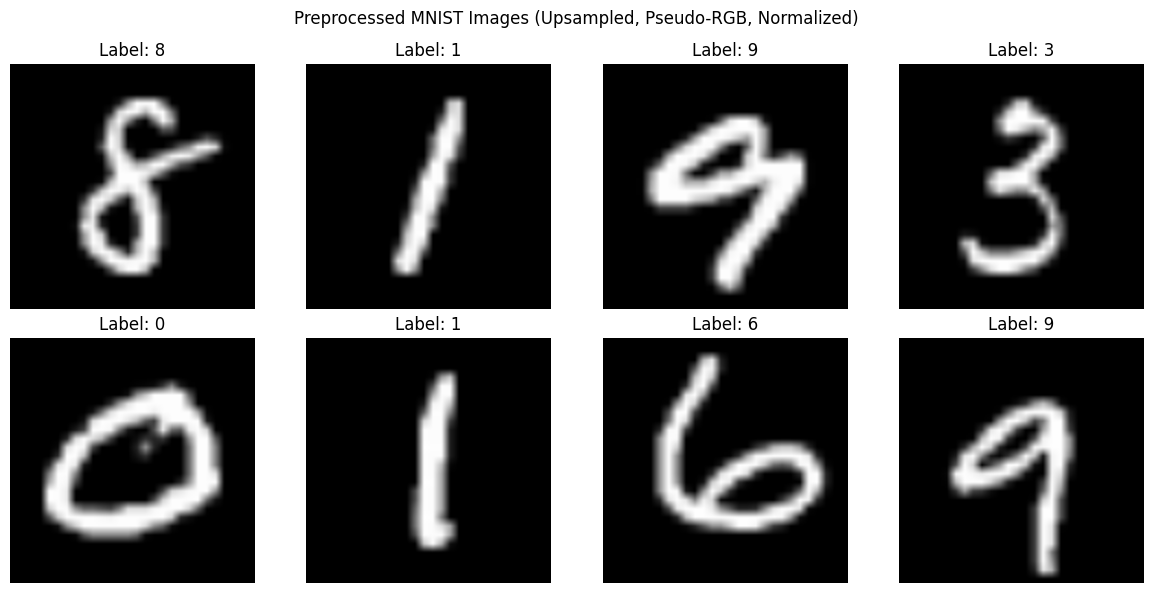

Image shape after preprocessing: torch.Size([3, 224, 224])


In [4]:
#Visualize a few preprocessed images (denormalize for display)
def denormalize_for_display(image):
# image shape: (3, 224, 224), already in [0,1]
    image = (image.numpy() * 255.0).astype('uint8')
    return image.transpose(1, 2, 0)  # CHW to HWC for imshow

plt.figure(figsize=(12, 6))
data_iter = iter(train_loader)
image_batch, label_batch = next(data_iter)

for j in range(min(8, len(image_batch))):  # Show up to 8 images
    plt.subplot(2, 4, j+1)
    img_display = denormalize_for_display(image_batch[j])
    plt.imshow(img_display)
    plt.title(f'Label: {label_batch[j].item()}')
    plt.axis('off')
plt.suptitle('Preprocessed MNIST Images (Upsampled, Pseudo-RGB, Normalized)')
plt.tight_layout()
plt.show()

print(f"Image shape after preprocessing: {image_batch.shape[1:]}")  # torch.Size([224, 224, 3])

## Use Efficientnet_B0 as Pre-trained base model (Feature Extractor)

In [5]:
# Load pre-trained MobileNetV2 base model (equivalent to include_top=False)
base_model = models.efficientnet_b0(pretrained=True)
base_model.classifier = nn.Identity()  # Remove the classifier to mimic include_top=False
# base_model.features outputs shape [batch, 1280, 7, 7]

# Define the head model for MNIST (10 classes)
class Head(nn.Module):
    def __init__(self, num_classes=10):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(1280, 128)  # 1280 from MobileNetV2 features
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)  # Updated for 10 MNIST classes
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        # x = self.softmax(self.fc2(x))
        x = self.fc2(x)
        return x

# Create the full model: base + head
model = nn.Sequential(base_model, Head(num_classes=10))

# Freeze the base model layers (equivalent to trainable=False)
for param in base_model.parameters():
    param.requires_grad = False

# Define loss and optimizer (equivalent to compile)
criterion = nn.CrossEntropyLoss()  # Expects class indices (0-9 for MNIST); use with argmax on outputs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Default lr for Adam; adjust as needed

# Metrics: In PyTorch, accuracy is computed manually (e.g., in training loop)
# Example accuracy function (for 10-class MNIST):
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    return (predicted == labels).sum().item() / labels.size(0)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 224MB/s]


In [6]:
# model summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 224, 224))  # Input: (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## Training and Validation Pipeline

In [7]:
# Device and training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

# Training & Eval functions (with early stopping)
def train_epoch(model, loader, criterion, optimizer, device):
    print("train_epoch")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        # _, predicted = torch.max(outputs.data, 1)

        # Apply softmax to get probabilities: [batch_size, num_classes]
        # probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    print("evaluate")
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Apply softmax to get probabilities: [batch_size, num_classes]
            # probs = torch.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

Using device: cuda


In [8]:
# Train with early stopping
epochs = 10
patience = 3
best_val_acc = 0.0
patience_counter = 0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Early stopping & save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print('-' * 60)


Starting training...
train_epoch
evaluate
Epoch 1/10: Train Loss: 0.4440 | Train Acc: 0.8635 | Val Loss: 0.1429 | Val Acc: 0.9554
------------------------------------------------------------
train_epoch
evaluate
Epoch 2/10: Train Loss: 0.2667 | Train Acc: 0.9159 | Val Loss: 0.1170 | Val Acc: 0.9631
------------------------------------------------------------
train_epoch
evaluate
Epoch 3/10: Train Loss: 0.2488 | Train Acc: 0.9196 | Val Loss: 0.1094 | Val Acc: 0.9627
------------------------------------------------------------
train_epoch
evaluate
Epoch 4/10: Train Loss: 0.2329 | Train Acc: 0.9250 | Val Loss: 0.1035 | Val Acc: 0.9659
------------------------------------------------------------
train_epoch
evaluate
Epoch 5/10: Train Loss: 0.2201 | Train Acc: 0.9283 | Val Loss: 0.1148 | Val Acc: 0.9650
------------------------------------------------------------
train_epoch
evaluate
Epoch 6/10: Train Loss: 0.2140 | Train Acc: 0.9296 | Val Loss: 0.0980 | Val Acc: 0.9683
--------------------

## Accuracy and Loss

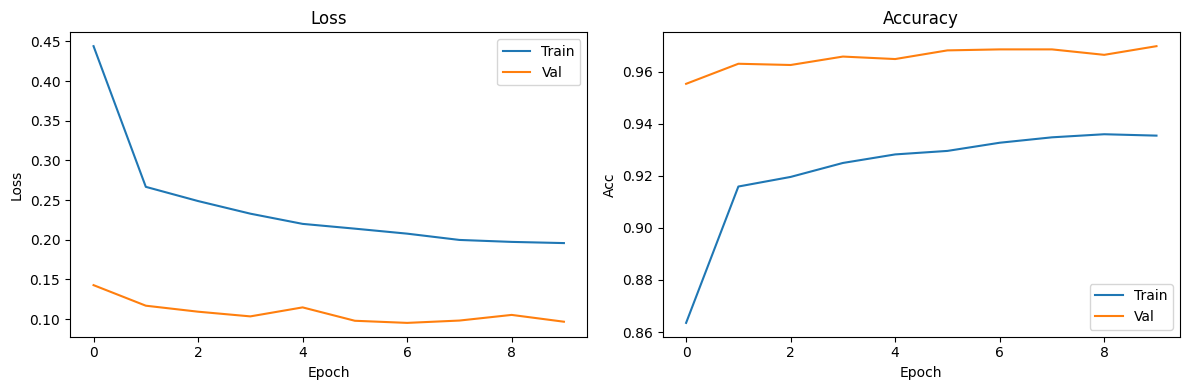

In [9]:
# Plot curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.title('Accuracy')
plt.tight_layout()
plt.show()

## Model Evaluating

In [10]:
# Final test
model.load_state_dict(torch.load('best_mnist_model.pth'))  # Load best
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'\nFinal Test: Loss {test_loss:.4f} | Acc {test_acc:.4f}')

evaluate

Final Test: Loss 0.1021 | Acc 0.9691


## Sample Prediction

Sample Prediction: True=3, Pred=3, Confidence=0.5056


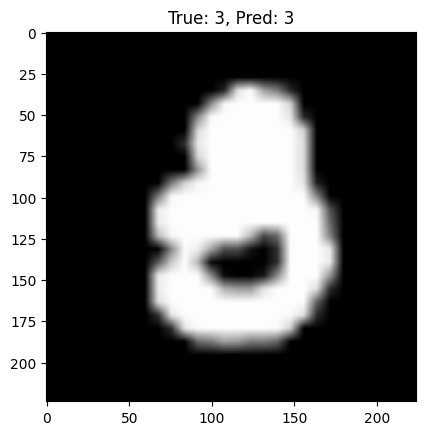

In [11]:
# Inference on a sample (e.g., first test image)
model.eval()
sample_img, sample_label = next(iter(test_loader))
sample_img = sample_img[0:1].to(device)  # Single image
with torch.no_grad():
    output = model(sample_img)
    probs = F.softmax(output, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    conf = probs[0][pred].item()

print(f"Sample Prediction: True={sample_label[0].item()}, Pred={pred}, Confidence={conf:.4f}")
plt.imshow(sample_img.squeeze().cpu().permute(1,2,0)); plt.title(f'True: {sample_label[0].item()}, Pred: {pred}'); plt.show()